In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from __future__ import print_function

import math

from sklearn import tree
from sklearn.model_selection import train_test_split

get_ipython().magic(u'matplotlib inline') #para imprimir no próprio notebook

%matplotlib inline
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from __future__ import print_function


from sklearn.model_selection import train_test_split
from sklearn import tree

In [2]:
#Funções auxiliares
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots(figsize = (12,10))
    cmap = sns.diverging_palette(220,10, as_cmap=True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax, 
        annot=True, 
        annot_kws={'fontsize':12}
    )
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df,row = row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
#Adaptado de https://www.kaggle.com/sachinkulkarni/titanic/an-interactive-data-science-tutorial
#carrega a base de dados
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
full_data = [train, test]

In [4]:
#Identifica as características presentes
train.columns.values

#Descrição das variáveis
#We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:
#Variable Description
#Survived: Survived (1) or died (0)
#Pclass: Passenger's class
#Name: Passenger's name
#Sex: Passenger's sex
#Age: Passenger's age
#SibSp: Number of siblings/spouses aboard
#Parch: Number of parents/children aboard
#Ticket: Ticket number
#Fare: Fare
#Cabin: Cabin
#Embarked: Port of embarkation

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [5]:
#Cria a base de treinamento para o projeto (70% das amostras)
full = train.append(test , ignore_index = True)
titanic = full[: train.shape[0]]
print("Datasets:\nCompleto: " , full.shape, "\nTreinamento:", titanic.shape)


Datasets:
Completo:  (1309, 12) 
Treinamento: (891, 12)


In [6]:
#Imprime as primeiras amostras, juntamento com o cabeçalho
titanic.head()



Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0            373450

In [7]:
#Análise dos dados. Observe que é possível identificar dados inconsistentes. Por exemplo, idade mínima de 0.42!
titanic.describe()


/home/leyza/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Age        Fare       Parch  PassengerId      Pclass  \
count  714.000000  891.000000  891.000000   891.000000  891.000000   
mean    29.699118   32.204208    0.381594   446.000000    2.308642   
std     14.526497   49.693429    0.806057   257.353842    0.836071   
min      0.420000    0.000000    0.000000     1.000000    1.000000   
25%           NaN    7.910400    0.000000   223.500000    2.000000   
50%           NaN   14.454200    0.000000   446.000000    3.000000   
75%           NaN   31.000000    0.000000   668.500000    3.000000   
max     80.000000  512.329200    6.000000   891.000000    3.000000   

            SibSp    Survived  
count  891.000000  891.000000  
mean     0.523008    0.383838  
std      1.102743    0.486592  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      1.000000    1.000000  
max      8.000000    1.000000

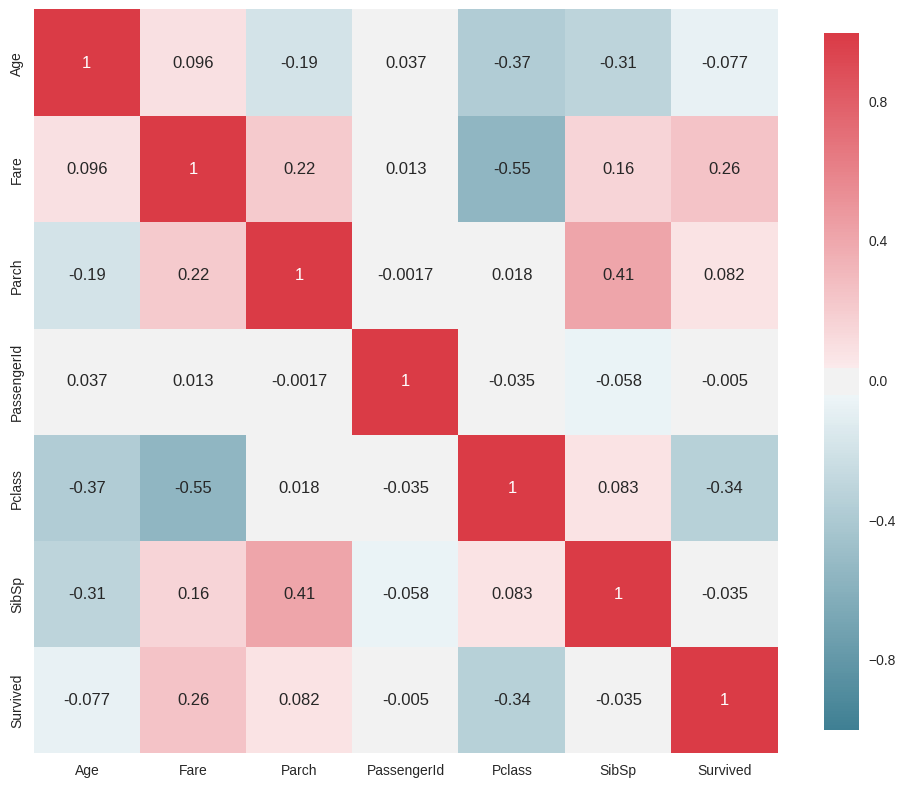

In [8]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(titanic)

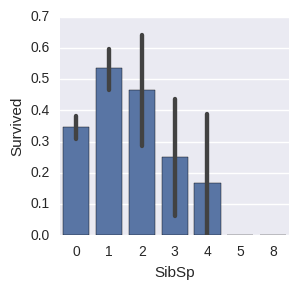

In [9]:
#Distribuição das amostras dentro de uma mesma classe
#Visualize a "Survival Rate" em relação aos seguintes atributos: Embarked, Sex, Pclass, SibSp, Parch
plot_categories(titanic, cat = 'SibSp', target = 'Survived')

In [10]:
#A PARTIR DESTE PONTO SÃO CARREGADOS E PROCESSADOS OS ATRIBUTOS

In [11]:
#Altera o atributo "Sex" de valores nominais (Male/Female)para 0 e 1
sex = pd.Series(np.where(full.Sex=='male', 1, 0), name = 'Sex')


In [12]:
#Cria uma nova variável para cada valor único de "Embarked" (no caso, Embarked_C  Embarked_Q  Embarked_S)
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')
print(embarked.head())
#Cria uma nova variável para cada valor único de "Pclass"
pclass = pd.get_dummies(full.Pclass , prefix='Pclass' )
print(pclass.head())

   Embarked_C  Embarked_Q  Embarked_S
0         0.0         0.0         1.0
1         1.0         0.0         0.0
2         0.0         0.0         1.0
3         0.0         0.0         1.0
4         0.0         0.0         1.0
   Pclass_1  Pclass_2  Pclass_3
0       0.0       0.0       1.0
1       1.0       0.0       0.0
2       0.0       0.0       1.0
3       1.0       0.0       0.0
4       0.0       0.0       1.0


In [13]:
#Muitos algoritmos requerem que todas as amostras possuam valores atribuídos para todas as características. 
#No caso de dados faltantes, uma possibilidade é preenchê-los com o valor médio das demais observações.

#Cria o dataset
imputed = pd.DataFrame()

#Preenche os valores que faltam em "Age" com a média das demais idades
imputed['Age'] = full.Age.fillna(full.Age.mean())

#O mesmo para "Fare"
imputed['Fare'] = full.Fare.fillna(full.Fare.mean())

imputed.head()

Age     Fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
3  35.0  53.1000
4  35.0   8.0500

In [14]:
#As distinções refletiam o status social e podem ser utilziados para prever a probabilidade de sobrevivência

title = pd.DataFrame()

#Extrai o título de cada nome
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

#Lista agregada de títulos
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

#Faz o mapeamento de cada título
title['Title'] = title.Title.map(Title_Dictionary)
#Cria uma nova variável para cada título
title = pd.get_dummies(title.Title)

title.head()

Master  Miss   Mr  Mrs  Officer  Royalty
0     0.0   0.0  1.0  0.0      0.0      0.0
1     0.0   0.0  0.0  1.0      0.0      0.0
2     0.0   1.0  0.0  0.0      0.0      0.0
3     0.0   0.0  0.0  1.0      0.0      0.0
4     0.0   0.0  1.0  0.0      0.0      0.0

In [15]:
#Extrai a categoria da cabine a partir do número
cabin = pd.DataFrame()

#Substitui dados faltantes por "U" (Uknown)
cabin['Cabin'] = full.Cabin.fillna( 'U' )

#Mapeia cada valor de cabine com a letra
cabin['Cabin'] = cabin['Cabin'].map(lambda c : c[0])

#Cria uma variável para cada categoria
cabin = pd.get_dummies(cabin['Cabin'] , prefix = 'Cabin')

cabin.head()

Cabin_A  Cabin_B  Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Cabin_U  
0      1.0  
1      0.0  
2      1.0  
3      0.0  
4      1.0

In [16]:
#Extrai a classe de cada ticket a partir do seu número
#Caso não tenha prefixo, retorna XXX
def cleanTicket( ticket ):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

#Cria uma nova variável para cada caso
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

Ticket_A  Ticket_A4  Ticket_A5  Ticket_AQ3  Ticket_AQ4  Ticket_AS  \
0       0.0        0.0        1.0         0.0         0.0        0.0   
1       0.0        0.0        0.0         0.0         0.0        0.0   
2       0.0        0.0        0.0         0.0         0.0        0.0   
3       0.0        0.0        0.0         0.0         0.0        0.0   
4       0.0        0.0        0.0         0.0         0.0        0.0   

   Ticket_C  Ticket_CA  Ticket_CASOTON  Ticket_FC     ...      Ticket_SOTONO2  \
0       0.0        0.0             0.0        0.0     ...                 0.0   
1       0.0        0.0             0.0        0.0     ...                 0.0   
2       0.0        0.0             0.0        0.0     ...                 0.0   
3       0.0        0.0             0.0        0.0     ...                 0.0   
4       0.0        0.0             0.0        0.0     ...                 0.0   

   Ticket_SOTONOQ  Ticket_SP  Ticket_STONO  Ticket_STONO2  Ticket_STONOQ  \
0             0.0        0.0           0.0            0.0            0.0   
1             0.0        0.0           0.0            0.0            0.0   
2             0.0        0.0           0.0            1.0            0.0   
3             0.0        0.0           0.0            0.0            0.0   
4             0.0        0.0           0.0            0.0            0.0   

   Ticket_SWPP  Ticket_WC  Ticket_WEP  Ticket_XXX  
0          0.0        0.0         0.0         0.0  
1          0.0        0.0         0.0         0.0  
2          0.0        0.0         0.0         0.0  
3          0.0        0.0         0.0         1.0  
4          0.0        0.0         0.0         1.0  

[5 rows x 37 columns]

In [17]:
#Cria variáveis para representar o tamanho da família e também cada categoria
family = pd.DataFrame()

#Cria nova característica que representa o tamanho da família (quantidade de membros)
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

#Cria nova características para representar o tipo de família 
family['Family_Single'] = family['FamilySize'].map(lambda s : 1 if s == 1 else 0)
family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 5 <= s else 0)

family.head()

FamilySize  Family_Single  Family_Small  Family_Large
0           2              0             1             0
1           2              0             1             0
2           1              1             0             0
3           2              0             1             0
4           1              1             0             0

In [18]:
#Seleciona as características que serão incluídas no descritor (vetor de características)
full_X = pd.concat([imputed, embarked, family, sex, title] , axis=1)
full_X.head()

Age     Fare  Embarked_C  Embarked_Q  Embarked_S  FamilySize  \
0  22.0   7.2500         0.0         0.0         1.0           2   
1  38.0  71.2833         1.0         0.0         0.0           2   
2  26.0   7.9250         0.0         0.0         1.0           1   
3  35.0  53.1000         0.0         0.0         1.0           2   
4  35.0   8.0500         0.0         0.0         1.0           1   

   Family_Single  Family_Small  Family_Large  Sex  Master  Miss   Mr  Mrs  \
0              0             1             0    1     0.0   0.0  1.0  0.0   
1              0             1             0    0     0.0   0.0  0.0  1.0   
2              1             0             0    0     0.0   1.0  0.0  0.0   
3              0             1             0    0     0.0   0.0  0.0  1.0   
4              1             0             0    1     0.0   0.0  1.0  0.0   

   Officer  Royalty  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0

In [19]:
#A PARTIR DAQUI, COMEÇA O PROCESSO DE CLASSIFICAÇÃO!

#A partir apenas das amostras do arquivo train.csv, cria a base de treinamento e teste.
X = full_X[0:train.shape[0]]
y = titanic.Survived

X_train, X_test, y_train, y_test = train_test_split(X , y, train_size = .8)

clf = tree.DecisionTreeClassifier(criterion='gini')
clf = clf.fit(X_train, y_train)
preditor = clf.predict(X_test)